### Daytum Course: Spatial Data Analytics

### Spatial Estimation / Kriging Demonstration and Exercise

Calculate spatial estimates away from spatial samples for:

* facies with indicator ordinary kriging

* porosity by-facies with ordinary kriging

#### Description

Here's a simple, documented workflow, demonstration of spaital estimation for subsurface modeling workflows. This should help you get started with building subsurface models that predict away from available data.  

Here's a simple workflow for spatial estimation with kriging and indicator kriging. This step is critical for:

1. Prediction away from wells, e.g. pre-drill assessments.
2. Spatial cross validation.
3. Spatial uncertainty modeling.

First let's explain the concept of spatial estimation.

#### Spatial Estimation

Consider the case of making an estimate at some unsampled location, $𝑧(\bf{u}_0)$, where $z$ is the property of interest (e.g. porosity etc.) and $𝐮_0$ is a location vector describing the unsampled location.

How would you do this given data, $𝑧(\bf{𝐮}_1)$, $𝑧(\bf{𝐮}_2)$, and $𝑧(\bf{𝐮}_3)$?

It would be natural to use a set of linear weights to formulate the estimator given the available data.

\begin{equation}
z^{*}(\bf{u}) = \sum^{n}_{\alpha = 1} \lambda_{\alpha} z(\bf{u}_{\alpha})
\end{equation}

We could add an unbiasedness constraint to impose the sum of the weights equal to one.  What we will do is assign the remainder of the weight (one minus the sum of weights) to the global average; therefore, if we have no informative data we will estimate with the global average of the property of interest.

\begin{equation}
z^{*}(\bf{u}) = \sum^{n}_{\alpha = 1} \lambda_{\alpha} z(\bf{u}_{\alpha}) + \left(1-\sum^{n}_{\alpha = 1} \lambda_{\alpha} \right) \overline{z}
\end{equation}

We will make a stationarity assumption, so let's assume that we are working with residuals, $y$. 

\begin{equation}
y^{*}(\bf{u}) = z^{*}(\bf{u}) - \overline{z}(\bf{u})
\end{equation}

If we substitute this form into our estimator the estimator simplifies, since the mean of the residual is zero.

\begin{equation}
y^{*}(\bf{u}) = \sum^{n}_{\alpha = 1} \lambda_{\alpha} y(\bf{u}_{\alpha})
\end{equation}

while satisfying the unbaisedness constraint.  

#### Kriging

Now the next question is what weights should we use?  

We could use equal weighting, $\lambda = \frac{1}{n}$, and the estimator would be the average of the local data applied for the spatial estimate. This would not be very informative.

We could assign weights considering the spatial context of the data and the estimate:

* **spatial continuity** as quantified by the variogram (and covariance function)
* **redundancy** the degree of spatial continuity between all of the available data with themselves 
* **closeness** the degree of spatial continuity between the avaiable data and the estimation location

The kriging approach accomplishes this, calculating the best linear unbiased weights for the local data to estimate at the unknown location.  The derivation of the kriging system and the resulting linear set of equations is available in the lecture notes.  Furthermore kriging provides a measure of the accuracy of the estimate!  This is the kriging estimation variance (sometimes just called the kriging variance).

\begin{equation}
\sigma^{2}_{E}(\bf{u}) = C(0) - \sum^{n}_{\alpha = 1} \lambda_{\alpha} C(\bf{u}_0 - \bf{u}_{\alpha})
\end{equation}

What is 'best' about this estimate? Kriging estimates are best in that they minimize the above estimation variance. 

#### Properties of Kriging

Here are some important properties of kriging:

* **Exact interpolator** - kriging estimates with the data values at the data locations
* **Kriging variance** can be calculated before getting the sample information, as the kriging estimation variance is not dependent on the values of the data nor the kriging estimate, i.e. the kriging estimator is homoscedastic. 
* **Spatial context** - kriging takes into account, furthermore to the statements on spatial continuity, closeness and redundancy we can state that kriging accounts for the configuration of the data and structural continuity of the variable being estimated.
* **Scale** - kriging may be generalized to account for the support volume of the data and estimate. We will cover this later.
* **Multivariate** - kriging may be generalized to account for multiple secondary data in the spatial estimate with the cokriging system. We will cover this later.
* **Smoothing effect** of kriging can be forecast. We will use this to build stochastic simulations later.

#### Load the required libraries

The following code loads the required libraries.

In [1]:
import geostatspy.GSLIB as GSLIB                       # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats                 # GSLIB methods convert to Python    

C:\Users\pm27995\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\pm27995\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\pm27995\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


We will also need some standard packages. These should have been installed with Anaconda 3.

In [2]:
import os                                               # to set current working directory 
import numpy as np                                      # arrays and matrix math
import pandas as pd                                     # DataFrames
import matplotlib.pyplot as plt                         # plotting
from intake import cat
import warnings
warnings.filterwarnings('ignore')

#### Loading Tabular Data

Here's the command to load our comma delimited data file in to a Pandas' DataFrame object. 

In [7]:
df = pd.read_csv(r'https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/sample_data_biased.csv') # load the data from Dr. Pyrcz's github repository
#df = cat.sample_data_MV_biased.read()                     # read a .csv file in as a DataFrame
df_sand = pd.DataFrame.copy(df[df['Facies'] == 1]).reset_index()  # copy only 'Facies' = sand records
df_shale = pd.DataFrame.copy(df[df['Facies'] == 0]).reset_index() # copy only 'Facies' = shale records
#print(df.iloc[0:5,:])                                  # display first 4 samples in the table as a preview
df.head()                                               # we could also use this command for a table preview 

,X,Y,Facies,Porosity,Perm
0,100,900,1,0.115359,5.736104
1,100,800,1,0.136425,17.211462
2,100,600,1,0.135810,43.724752
3,100,500,0,0.094414,1.609942
4,100,100,0,0.113049,10.886001


Let's look at summary statistics for all facies combined:

In [8]:
df.describe().transpose()                          # summary table of all facies combined DataFrame statistics
df_sand.describe().transpose()                     # summary table of sand only DataFrame statistics
df_shale.describe().transpose()                    # summary table of shale only DataFrame statistics

,count,mean,std,min,25%,50%,75%,max
index,54.0,163.351852,79.533583,3.000000,109.500000,165.500000,231.500000,287.000000
X,54.0,453.518519,357.175278,0.000000,112.500000,485.000000,785.000000,990.000000
Y,54.0,418.351852,279.999404,9.000000,211.500000,429.000000,597.250000,989.000000
Facies,54.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Porosity,54.0,0.093164,0.012882,0.058548,0.084734,0.094569,0.101563,0.122770
Perm,54.0,2.018825,2.148730,0.075819,0.757300,1.524405,2.530171,11.076648


Let's also look at the distributions.  

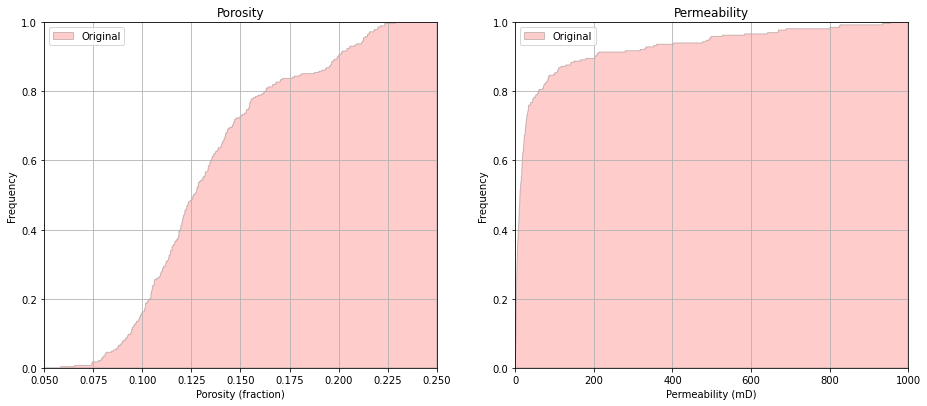

In [9]:
plt.subplot(121)                                        # plot original sand and shale porosity histograms
plt.hist(df['Porosity'], facecolor='red',bins=np.linspace(0.0,0.25,1000),histtype="stepfilled",alpha=0.2,density=True,cumulative=True,edgecolor='black',label='Original')
plt.xlim([0.05,0.25]); plt.ylim([0,1.0])
plt.xlabel('Porosity (fraction)'); plt.ylabel('Frequency'); plt.title('Porosity')
plt.legend(loc='upper left')
plt.grid(True)

plt.subplot(122)                                        # plot nscore transformed sand and shale histograms
plt.hist(df['Perm'], facecolor='red',bins=np.linspace(0.0,1000.0,100000),histtype="stepfilled",alpha=0.2,density=True,cumulative=True,edgecolor='black',label='Original')
plt.xlim([0.0,1000.0]); plt.ylim([0,1.0])
plt.xlabel('Permeability (mD)'); plt.ylabel('Frequency'); plt.title('Permeability')
plt.legend(loc='upper left')
plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.3)
plt.show()

We can observe from the CDFs that the porosity distribution is 'Gaussian-like' in shape, while the permeability distribution is 'lognormal-like'.  They both look well behaved.

For brevity we will omit data declustering from this workflow. We will assume declustered means for the porosity and permeability to apply with simple kriging.

Let's plot the location maps of porosity and permeability for all facies. We will also include a cross plot of permeability vs. porosity colored by facies to aid with comparison in spatial features between the porosity and permeability data.

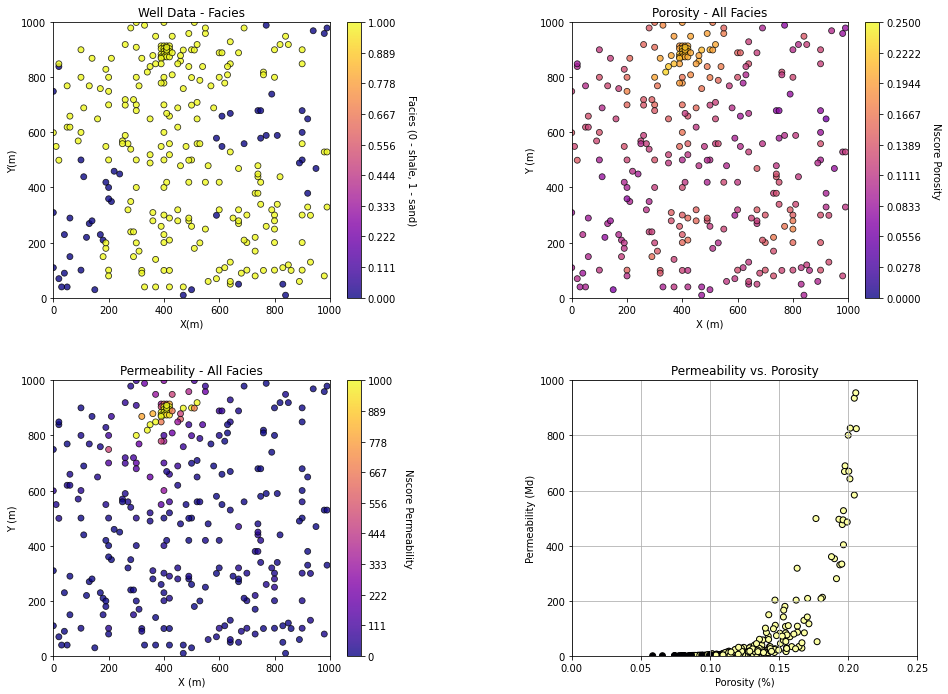

In [10]:
xmin = 0.0; xmax = 1000.0               # range of x values
ymin = 0.0; ymax = 1000.0               # range of y values

xsiz = 10; ysiz = 10                    # cell size
nx = 100; ny = 100                      # number of cells
xmn = 5; ymn = 5                        # grid origin, location center of lower left cell

cmap = plt.cm.plasma                    # color map
GSLIB.locmap_st(df,'X','Y','Facies',xmin,xmax,ymin,ymax,0,1,'Well Data - Facies','X(m)','Y(m)','Facies (0 - shale, 1 - sand)',cmap)

plt.subplot(221)
GSLIB.locmap_st(df,'X','Y','Facies',xmin,xmax,ymin,ymax,0,1,'Well Data - Facies','X(m)','Y(m)','Facies (0 - shale, 1 - sand)',cmap)

plt.subplot(222)
GSLIB.locmap_st(df,'X','Y','Porosity',0,1000,0,1000,0,0.25,'Porosity - All Facies','X (m)','Y (m)','Nscore Porosity',cmap)

plt.subplot(223)
GSLIB.locmap_st(df,'X','Y','Perm',0,1000,0,1000,0,1000,'Permeability - All Facies','X (m)','Y (m)','Nscore Permeability',cmap)

plt.subplot(224)
facies = df['Facies'].values +0.01
plt.scatter(df['Porosity'],df['Perm'],c = facies,edgecolor = 'black',cmap = plt.cm.inferno)
#plt.plot([-3,3],[-3,3],color = 'black')
plt.xlabel(r'Porosity (%)')
plt.ylabel(r'Permeability (Md)')
plt.title('Permeability vs. Porosity')
plt.xlim([0,0.25])
plt.ylim([0,1000])
plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.2, wspace=0.5, hspace=0.3)
plt.show()

We will now separate the data and visualize the porosity and permeability location maps by facies.  For our by-facies spatial estimation workflow we will separate the data by-facies.

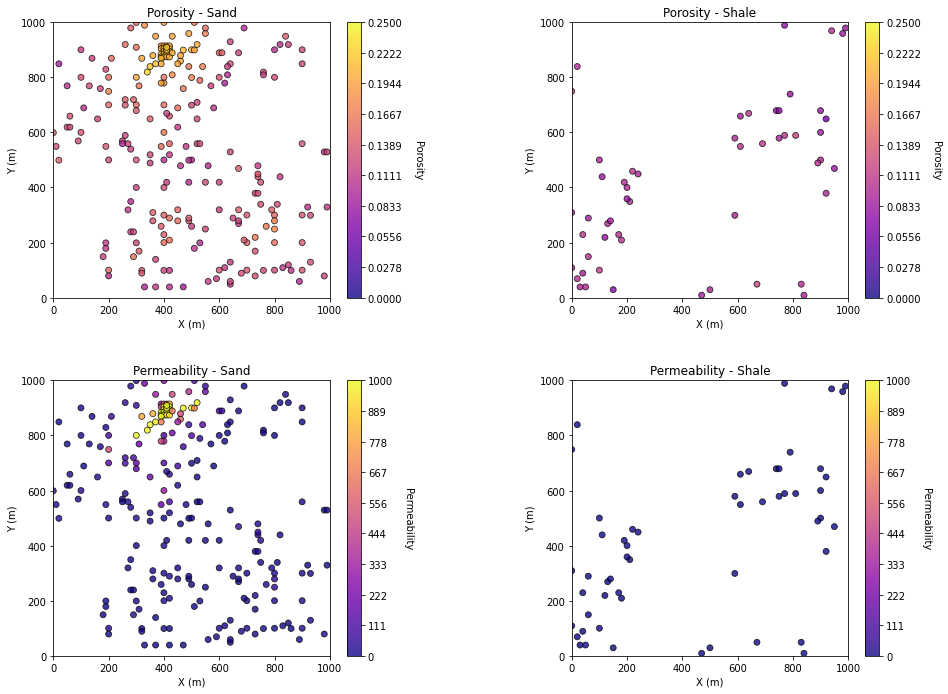

In [11]:
plt.subplot(221)
GSLIB.locmap_st(df_sand,'X','Y','Porosity',0,1000,0,1000,0,0.25,'Porosity - Sand','X (m)','Y (m)','Porosity',cmap)

plt.subplot(222)
GSLIB.locmap_st(df_shale,'X','Y','Porosity',0,1000,0,1000,0,0.25,'Porosity - Shale','X (m)','Y (m)','Porosity',cmap)

plt.subplot(223)
GSLIB.locmap_st(df_sand,'X','Y','Perm',0,1000,0,1000,0,1000,'Permeability - Sand','X (m)','Y (m)','Permeability',cmap)

plt.subplot(224)
GSLIB.locmap_st(df_shale,'X','Y','Perm',0,1000,0,1000,0,1000,'Permeability - Shale','X (m)','Y (m)','Permeability',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.2, wspace=0.5, hspace=0.3)
plt.show()

#### Indicator Kriging for Facies 

To demonstrate kriging we will assume variogram models, rather than calculate experimental variograms and then model them.  This is for brevity and so we can be free to experiment with different vairogram models to observe the impact on kriging.

Let's first set up the basic indicator kriging parameters:

In [12]:
nxdis = 1; nydis = 1                       # block kriging discretizations, 1 for point kriging
ndmin = 0; ndmax = 10                      # minimum and maximum data for kriging 
radius = 100                               # maximum search distance
ktype = 1                                  # kriging type, 0 - simple, 1 - ordinary
ivtype = 0                                 # variable type, 0 - categorical, 1 - continuous
tmin = -999; tmax = 999;                   # data trimming limits

Now, let's specify the facies categories, global proportions along with the spatial continuity models for both facies.

In [13]:
ncut = 2                                   # number of facies
thresh = [0,1]                             # the facies categories
gcdf = [0.4,0.6]                           # the global proportions of the categories
varios = []                                # the variogram list
varios.append(GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0,hmaj1=50,hmin1=40)) # shale indicator variogram
varios.append(GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0,hmaj1=50,hmin1=40)) # sand indicator variogram

We are ready to run the indicator kriging with the 2 cateogries (sand and shale) and calculate the probability of sand and shale at all locations and plot the results.

Data for IK3D: Variable column Facies
  Number   = 289
Setting up rotation matrices for variogram and search
Working on the kriging
   currently on estimate 0
   currently on estimate 1000
   currently on estimate 2000
   currently on estimate 3000
   currently on estimate 4000
   currently on estimate 5000
   currently on estimate 6000
   currently on estimate 7000
   currently on estimate 8000
   currently on estimate 9000


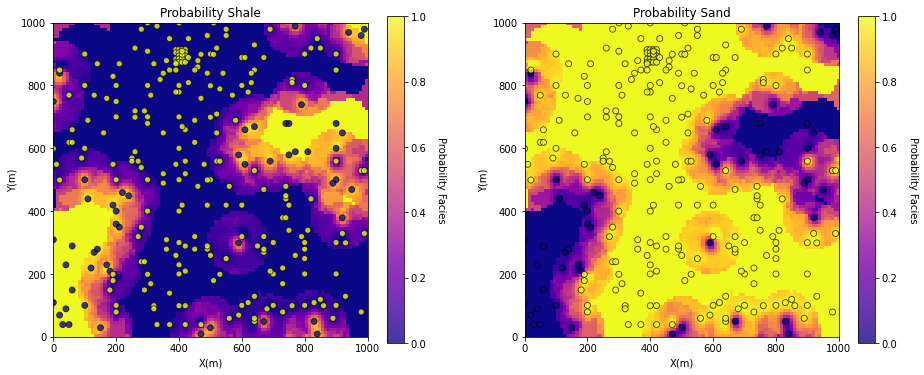

In [14]:
no_trend = np.zeros((1,1))                  # null ndarray not of correct size so ik2d will not use a trend - will fix this
ikmap = geostats.ik2d(df,'X','Y','Facies',ivtype,0,2,thresh,gcdf,no_trend,tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz, ndmin,ndmax,radius,ktype,vario=varios)

plt.subplot(221) 
GSLIB.locpix_st(ikmap[:,:,0],xmin,xmax,ymin,ymax,xsiz,0.0,1.0,df,'X','Y','Facies','Probability Shale','X(m)','Y(m)','Probability Facies',cmap)
plt.subplot(222) 
GSLIB.locpix_st(ikmap[:,:,1],xmin,xmax,ymin,ymax,xsiz,0.0,1.0,df,'X','Y','Facies','Probability Sand','X(m)','Y(m)','Probability Facies',cmap)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.5, wspace=0.2, hspace=0.2) 
plt.show()

The results are quite interesting.  With the use of ordinary kriging we are able to handle the nonstationarity in the sand a shale data.  See how the probability remains consistent away from data in locations with consistent facies. 

* For a surprising result, switch to simple kriging. We are actually using quite a short variogram range and we see the global proportions away from the data!

#### Kriging for Porosity and Permeability

Now let's try some kriging with the continuous properties. For this workflow we will demonstrate a cookie-cutter approach.  The steps are:

1. model the facies, sand and shale, probabilities with indicator kriging
2. model the porosity for sand and shale separately and exhaustively, i.e. at all locations in the model
3. model the permeability for sand and shale separately and exhaustively, i.e. at all locations in the model
4. assign sand and shale locations based on the probabilities from step 1 
5. combine the porosity and permeability from sand and shale regions together

Limitations of this Workflow:

* kriging is too smooth, the spatial continuity is too high
* kriging does not reproduce the continuous property distributions
* we are not accounting for the correlation between porosity and permeability 

We will correct these issues when we perform simulation later.

We need to add a couple of parameters and assume a porosity variogram model.


In [15]:
skmean_por = 0.10; skmean_perm = 65.0      # simple kriging mean (used if simple kriging is selected below)
ktype = 1                                  # kriging type, 0 - simple, 1 - ordinary
radius = 100                               # search radius for neighbouring data
nxdis = 1; nydis = 1                       # number of grid discretizations for block kriging (not tested)
ndmin = 0; ndmax = 10                      # minimum and maximum data for an estimate
tmin = 0.0                                 # minimum property value
por_vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0,hmaj1=100,hmin1=100) # porosity variogram

Let's start with spatial estimates of porosity and permeability with all facies combined. We will also look at the kriging estimation variance.

  Estimated   10000 blocks 
      average   0.12213695710937618  variance  0.0007104260202237794
  Estimated   10000 blocks 
      average   45.6866409394568  variance  12159.749607581758


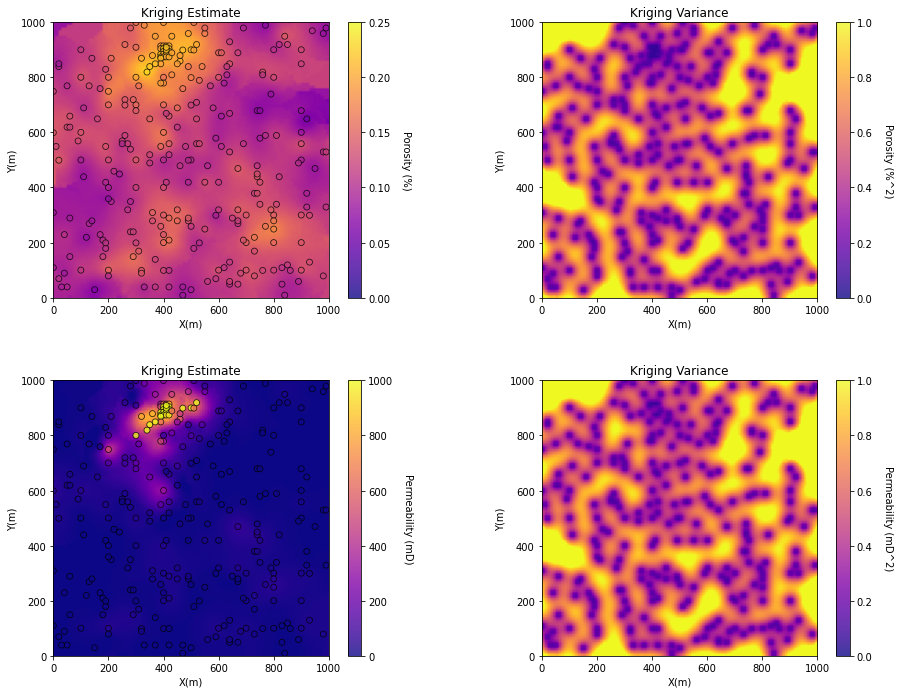

In [16]:
por_kmap, por_vmap = geostats.kb2d(df,'X','Y','Porosity',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
         ndmin,ndmax,radius,ktype,skmean_por,por_vario)

perm_kmap, perm_vmap = geostats.kb2d(df,'X','Y','Perm',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
         ndmin,ndmax,radius,ktype,skmean_perm,por_vario)

plt.subplot(221)
GSLIB.locpix_st(por_kmap,xmin,xmax,ymin,ymax,xsiz,0.0,0.25,df,'X','Y','Porosity','Kriging Estimate','X(m)','Y(m)','Porosity (%)',cmap)

plt.subplot(222)
GSLIB.pixelplt_st(por_vmap,xmin,xmax,ymin,ymax,xsiz,0.0,1.0,'Kriging Variance','X(m)','Y(m)','Porosity (%^2)',cmap)

plt.subplot(223)
GSLIB.locpix_st(perm_kmap,xmin,xmax,ymin,ymax,xsiz,0.0,1000,df,'X','Y','Perm','Kriging Estimate','X(m)','Y(m)','Permeability (mD)',cmap)

plt.subplot(224)
GSLIB.pixelplt_st(perm_vmap,xmin,xmax,ymin,ymax,xsiz,0.0,1.0,'Kriging Variance','X(m)','Y(m)','Permeability (mD^2)',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.2, wspace=0.3, hspace=0.3)
plt.show()

The results look good. There are a couple of 'blank values' in the permeability estimates, caused by negative estimates due to the extrapolation of kriging (negative weights with the screening effect).  In future releases of the package I will ensure that the kriging estimates are limited to the range set by the $tmin$ and $tmax$ parameters.  Nevertheless, this is instructive!

Now let's build spatial estimation models for sand and shale separately. Now we need variograms for sand and shale separately, along with the declustered global means if simple kriging is used.

In [17]:
skmean_por_sand = 0.10; skmean_por_shale = 0.05
skmean_perm_sand = 3.0; skmean_perm_shale = 0.5

por_sand_vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0,hmaj1=100,hmin1=100) # porosity sand variogram
por_shale_vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0,hmaj1=10,hmin1=10) # porosity shale variogram

perm_sand_vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0,hmaj1=100,hmin1=100) # perm sand variogram
perm_shale_vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0,hmaj1=10,hmin1=10) # perm shale variogram

facies_kmap = np.zeros((ny,nx)); por_kmap = np.zeros((ny,nx)); perm_kmap = np.zeros((ny,nx)) # declare array to combine values

We are now ready to run these models, by-facies and visualize the results.

  Estimated   10000 blocks 
      average   0.1287844942267923  variance  0.00048598315116487115
  Estimated   10000 blocks 
      average   47.737017190481964  variance  12008.663448140844
  Estimated   10000 blocks 
      average   0.09469333127808534  variance  0.00017643074619554285
  Estimated   10000 blocks 
      average   2.071807115060937  variance  3.1321712768300713


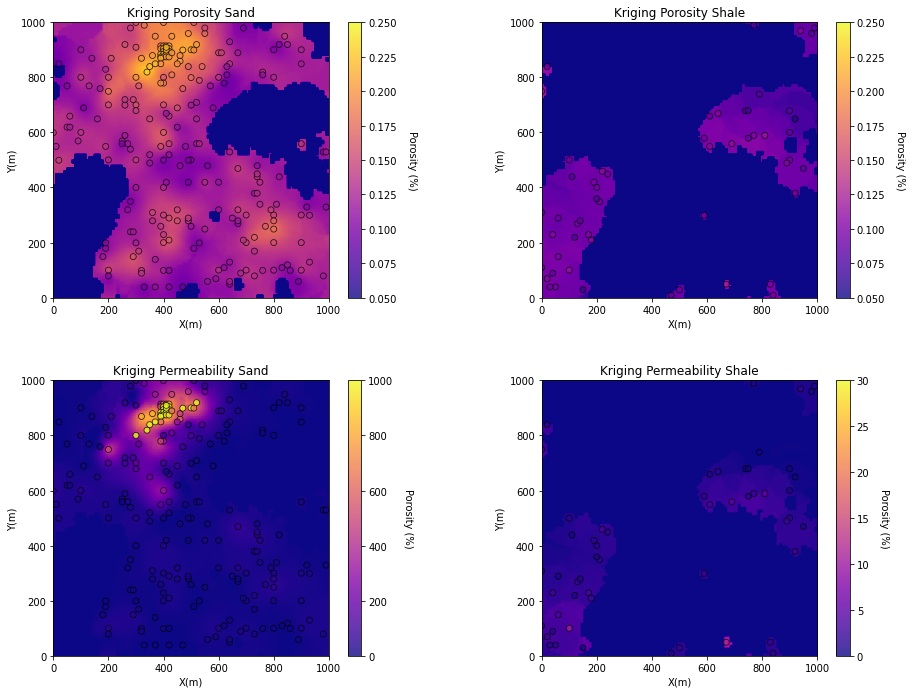

In [18]:
por_sand_kmap, por_sand_vmap = geostats.kb2d(df_sand,'X','Y','Porosity',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
         ndmin,ndmax,radius,ktype,skmean_por_sand,por_sand_vario)

perm_sand_kmap, perm_sand_vmap = geostats.kb2d(df_sand,'X','Y','Perm',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
         ndmin,ndmax,radius,ktype,skmean_perm_sand,perm_sand_vario)

por_shale_kmap, por_shale_vmap = geostats.kb2d(df_shale,'X','Y','Porosity',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
         ndmin,ndmax,radius,ktype,skmean_por_shale,por_shale_vario)

perm_shale_kmap, perm_shale_vmap = geostats.kb2d(df_shale,'X','Y','Perm',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
         ndmin,ndmax,radius,ktype,skmean_perm_shale,perm_shale_vario)

for iy in range(0,ny):
    for ix in range(0,nx):
        if ikmap[iy,ix,1] > 0.5:   # current location is assumed to be sand
            facies_kmap[iy,ix] = 1
            por_kmap[iy,ix] = por_sand_kmap[iy,ix];
            perm_kmap[iy,ix] = perm_sand_kmap[iy,ix];
            por_shale_kmap[iy,ix] = -1
            perm_shale_kmap[iy,ix] = -1
        else:                      # current location is assumed to be shale
            facies_kmap[iy,ix] = 0
            por_kmap[iy,ix] = por_shale_kmap[iy,ix];
            perm_kmap[iy,ix] = perm_shale_kmap[iy,ix];
            por_sand_kmap[iy,ix] = -1
            perm_sand_kmap[iy,ix] = -1

plt.subplot(221)
GSLIB.locpix_st(por_sand_kmap,xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df_sand,'X','Y','Porosity','Kriging Porosity Sand','X(m)','Y(m)','Porosity (%)',cmap)

plt.subplot(222)
GSLIB.locpix_st(por_shale_kmap,xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df_shale,'X','Y','Porosity','Kriging Porosity Shale','X(m)','Y(m)','Porosity (%)',cmap)

plt.subplot(223)
GSLIB.locpix_st(perm_sand_kmap,xmin,xmax,ymin,ymax,xsiz,0.0,1000,df_sand,'X','Y','Perm','Kriging Permeability Sand','X(m)','Y(m)','Porosity (%)',cmap)

plt.subplot(224)
GSLIB.locpix_st(perm_shale_kmap,xmin,xmax,ymin,ymax,xsiz,0.0,30,df_shale,'X','Y','Perm','Kriging Permeability Shale','X(m)','Y(m)','Porosity (%)',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.2, wspace=0.3, hspace=0.3)
plt.show()


Now let's visualize the estimation models for porosity and permeability by-facies put together as a single map for each property.

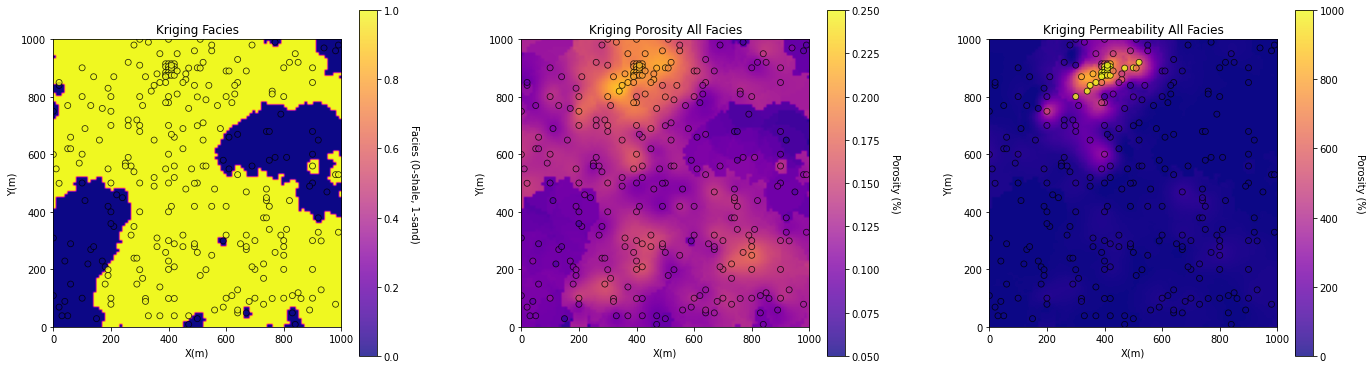

In [19]:
plt.subplot(131)
GSLIB.locpix_st(facies_kmap,xmin,xmax,ymin,ymax,xsiz,0,1,df,'X','Y','Facies','Kriging Facies','X(m)','Y(m)','Facies (0-shale, 1-sand)',cmap)

plt.subplot(132)
GSLIB.locpix_st(por_kmap,xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df,'X','Y','Porosity','Kriging Porosity All Facies','X(m)','Y(m)','Porosity (%)',cmap)

plt.subplot(133)
GSLIB.locpix_st(perm_kmap,xmin,xmax,ymin,ymax,xsiz,0.0,1000,df,'X','Y','Perm','Kriging Permeability All Facies','X(m)','Y(m)','Porosity (%)',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.2, wspace=0.3, hspace=0.3)
plt.show()

This is a basic demonstration of spatial estimation in Python.

I hope this was helpful,

*Michael*

#### The Author:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

<i>&copy; Copyright daytum 2021. All Rights Reserved</i>